<a href="https://colab.research.google.com/github/nicolaiberk/Imbalanced/blob/master/ActiveLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Active Learning with `ModAL`

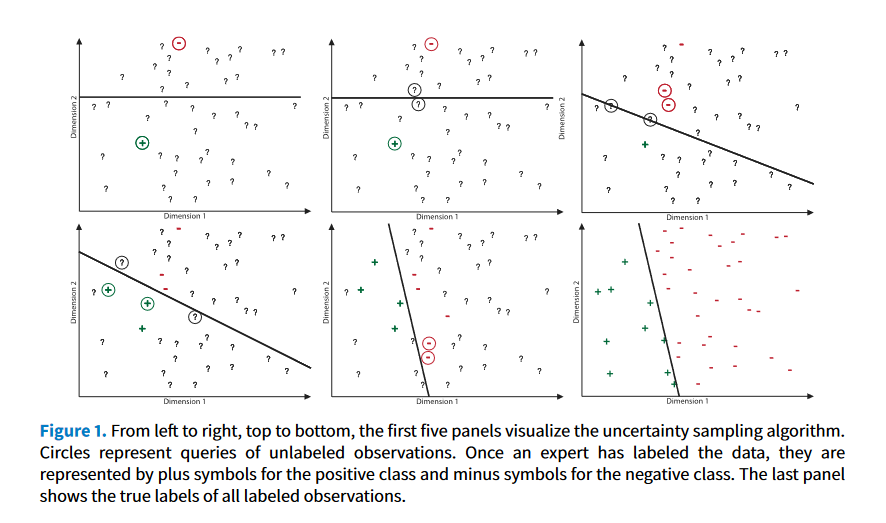

In [21]:
## setup and load data

# load relevant packages
import pandas as pd
import numpy as np
from copy import deepcopy
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

# set seed
np.random.seed(42)

# define vectoriser
vec = CountVectorizer()

# load data
corpus = pd.read_csv("https://www.dropbox.com/s/gv56nu1ptrp63ps/annotated_german_refugee_tweets.csv?dl=1")
corpus = corpus.sample(10000)

In [22]:
corpus.head()

,Unnamed: 0,tweet_id,annotation,text
19441,19458,662378425395585025,0.0,@Hej_Almira immerhin gibt's ein bisschen mehr ...
17244,17261,650791080292667392,0.0,@camilacabello97 ich liebe dich
11191,11203,615844453174128645,0.0,"@tagesschau Das war ein wichtiges Zeichen, den..."
1347,1347,556855741769056256,0.0,"Ich habe 12,049 Goldmünzen gesammelt! http://t..."
14148,14165,634391908463288320,0.0,@frolleinhoney ...wenn du das nach den Ficken ...


In [23]:
## we only need two variables: outcome and text
# corpus["annotation"] = corpus["toxic"]
corpus = corpus[["annotation", "text"]]

In [24]:
corpus.shape

(10000, 2)

In [25]:
# general train/test split for assessment of performance
#     and vectorize

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    corpus.text,
    corpus.annotation,
    test_size=0.20,
    random_state=42
)

# reset indices and vectorize text
X_train_raw = X_train_raw.reset_index(drop = True)
X_test_raw = X_test_raw.reset_index(drop = True)
X_train = vec.fit_transform(X_train_raw)
X_test = vec.transform(X_test_raw)
y_train = np.array(y_train.reset_index(drop = True))
y_test = np.array(y_test.reset_index(drop = True))

del corpus

# Application in Python

## Cold Phase/Initialisation

To start, we need a small random sample. This is necessary to train an initial classifier making uncertainty estimates about our unlabelled data. The size of this starting set will depend on the rareness of the outcome - it has to come up at least once. Let's try to sample 100 cases first:

13.0 positive cases out of a set of 500 in the starting set (2.6%).


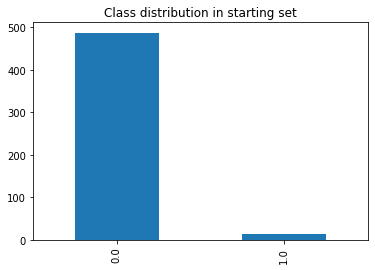

In [26]:
# draw random initialisation sample
n_initial = 500

rng = np.random.default_rng(42)
initial_idx = np.random.choice(range(X_train.shape[0]), size=n_initial, replace=False)

X_start = X_train[initial_idx]
y_start = y_train[initial_idx]

# drop starting sample from training sample
X_train = sparse.csr_matrix(np.delete(X_train.toarray(), initial_idx, axis=0))
y_train = np.delete(y_train, initial_idx)


print(f"{sum(y_start)} positive cases out of a set of {len(y_start)} in the starting set ({sum(y_start)*100/len(y_start)}%).")
pd.Series(y_start).value_counts().plot(kind='bar', title='Class distribution in starting set')

We have a few toxic comments in our dataset. It's not much, but it is sufficient to initialise our active learner.

## Active Phase

### General logic

In [27]:
# first install modAL package
!pip install modAL

In [28]:
# import modAL
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

# initializing the learner
learner = ActiveLearner(
    estimator=LogReg(max_iter=1000),
    X_training=X_start, y_training=y_start
)



In [29]:
# query for label
query_idx, query_inst = learner.query(X_train)

In [30]:
X_train_raw[query_idx].item()

'RT @dagibee: Wow, ich bin ÜBERWÄLTIGT über eure Unterstützung! 😭 ich hätte das nie nie nie nie erwartet ❤️ #bienchenfamily\n\n#KCA #VoteDagi …'

In [31]:
# supply label for queried instance
y_new = y_train[query_idx]

In [32]:
learner.teach(X_train[query_idx], y_new)

### Hand annotation

In [33]:
# we can also annotate by hand - check rubix for more info
n_queries = 3
for i in range(n_queries):
  
  # get most informative label
  query_idx, query_inst = learner.query(X_train)

  # print text
  display.clear_output(wait=True) # clear any existing text
  print(X_train_raw[query_idx].item())

  # display questions and text field
  print("\n\nIs this a tweet about refugees? ('1' = yes, '0' = no)?\n")
  y_new = np.array([int(input())], dtype=int)

  # update model
  learner.teach(query_inst, y_new)

  # delete coded example from training sample
  X_train, y_train = sparse.csr_matrix(np.delete(X_train.toarray(), query_idx, axis=0)), np.delete(y_train, query_idx)

Schöne Pfingsten

http://t.co/zSZhQnIvXW

Wir wünschen allen:

#Senioren

#Rentern

#Pensionären... http://t.co/86TBYSWRaB


Is this a tweet about refugees? ('1' = yes, '0' = no)?

0


### Batch Sampling and Comparative Performance

In [34]:
# train classifier on random sample for comparison

# draw sample
X_train_passive = X_start
y_train_passive = y_start

# define and fit classifier
passive_clsfr = LogReg(max_iter=1000)
passive_clsfr.fit(X_train_passive, y_train_passive)

# assess performance
y_pred_passive = passive_clsfr.predict(X_test)
accuracy_passive = [accuracy_score(y_test, y_pred_passive)]
recall_passive = [recall_score(y_test, y_pred_passive)]
precision_passive = [precision_score(y_test, y_pred_passive)]
f1_passive = [f1_score(y_test, y_pred_passive)]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
# define learner for batch sampling

from functools import partial
from modAL.batch import uncertainty_batch_sampling

# Pre-set our batch sampling to retrieve 50 samples at a time.
batch_size = 250
preset_batch = partial(uncertainty_batch_sampling, n_instances=batch_size)

# Specify our active learning model.
batch_learner = ActiveLearner(
  estimator=LogReg(max_iter=1000),

  X_training=X_start,
  y_training=y_start,

  query_strategy=preset_batch
)

# generate deepcopies from training set that can be used up
X_pool = deepcopy(X_train)
y_pool = deepcopy(y_train)

In [36]:
# performance of initialised active learner
accuracy_scores = [accuracy_score(y_test, batch_learner.predict(X_test))]
recall_scores = [recall_score(y_test, batch_learner.predict(X_test))]
precision_scores = [precision_score(y_test, batch_learner.predict(X_test))]
f1_scores = [f1_score(y_test, batch_learner.predict(X_test))]
training_progress = [n_initial]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


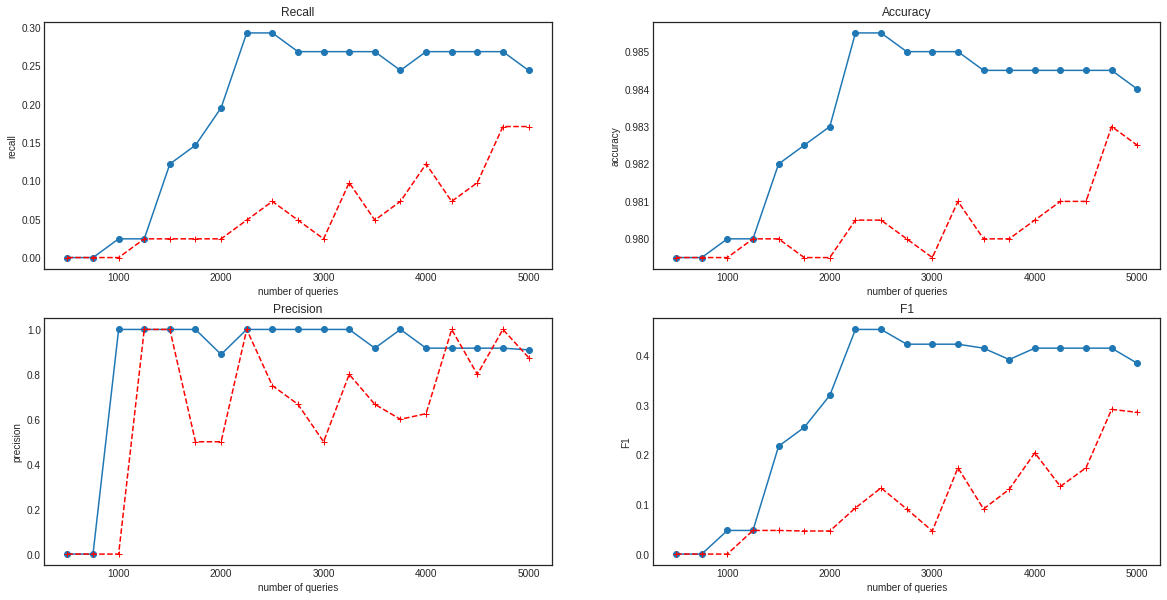

In [37]:
# this bit takes a while
learner_scores = [batch_learner.score(X_test, y_test)]

sample_size = 5000
n_queries = (sample_size - n_initial) // batch_size

for i in range(n_queries):

  # all that matters are the next few lines
  query_idx, query_inst = batch_learner.query(X_pool) # obtain uncertainty estimates for full training sample
  
  X, y = X_pool[query_idx], y_pool[query_idx]
  batch_learner.teach(X=X, y=y)
  
  ## assess performance
  training_progress.append(n_initial + (i+1)*batch_size)
  accuracy_scores.append(accuracy_score(y_test, batch_learner.predict(X_test)))
  recall_scores.append(recall_score(y_test, batch_learner.predict(X_test))) 
  precision_scores.append(precision_score(y_test, batch_learner.predict(X_test))) 
  active_f1 = f1_score(y_test, batch_learner.predict(X_test))
  f1_scores.append(active_f1) 
  
  print('Active F1 after query {n}: {acc:0.4f}'.format(n=i + 1, acc=active_f1))


  ## delete newly annotated from training pool
  X_pool, y_pool = sparse.csr_matrix(np.delete(X_pool.toarray(), query_idx, axis=0)), np.delete(y_pool, query_idx)


  # random classifier performance
  
  ## draw sample
  rand_sample = np.random.choice([i for i in range(len(y_train))], n_initial+(i+1)*batch_size, replace=False)
  X_train_passive = X_train[rand_sample]
  y_train_passive = y_train[rand_sample]

  ## define and fit classifier
  passive_clsfr = LogReg(max_iter=1000)
  passive_clsfr.fit(X_train_passive, y_train_passive)

  ## assess performance
  y_pred_passive = passive_clsfr.predict(X_test)
  accuracy_passive.append(accuracy_score(y_test, y_pred_passive))
  recall_passive.append(recall_score(y_test, y_pred_passive)) 
  precision_passive.append(precision_score(y_test, y_pred_passive)) 
  passive_f1 = f1_score(y_test, y_pred_passive)
  f1_passive.append(passive_f1) 

  print('Passive F1 after query {n}: {acc:0.4f}'.format(n=i + 1, acc=passive_f1))


  # the remainder is only for plotting

  display.clear_output(wait=True)
  with plt.style.context('seaborn-white'):
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 2, 1)
    plt.title('Recall')
    plt.plot(training_progress, recall_scores, marker = "o")
    plt.plot(training_progress, recall_passive, color = 'red', ls = "--", marker='+')
    plt.xlabel('number of queries')
    plt.ylabel('recall')
    plt.subplot(2, 2, 2)
    plt.title('Accuracy')
    plt.plot(training_progress, accuracy_scores, marker = "o")
    plt.plot(training_progress, accuracy_passive, color = 'red', ls = "--", marker='+')
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.subplot(2, 2, 3)
    plt.title('Precision')
    plt.plot(training_progress, precision_scores, marker = "o")
    plt.plot(training_progress, precision_passive, color = 'red', ls = "--", marker='+')
    plt.xlabel('number of queries')
    plt.ylabel('precision')
    plt.subplot(2, 2, 4)
    plt.title('F1')
    plt.plot(training_progress, f1_scores, marker = "o")
    plt.plot(training_progress, f1_passive, color = 'red', ls = "--", marker='+')
    plt.xlabel('number of queries')
    plt.ylabel('F1')
    display.display(plt.gcf())
    plt.close('all')      


In [38]:
sum(y_test)

41.0